# Exploratory Analysis

In this lesson, we will work through a framework for exploring and analyzing your data. 
The user-defined functions run in this lesson can be found in the section 'User-Defined Functions'. 

> Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns, to spot anomalies, to test hypotheses and to check assumptions with the help of summary statistics and graphical representations.
>
> [Prasad Patil, Novice Data Science Storyteller, Mar 23](https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15)

In this lesson, we will focus on the process of exploration. Why we do it, the process, asking questions, and gathering and documenting findings. The helper file, explore.py, contains the detailed code that creates the functions we use here. The recommended process for going through this lesson is to understand the flow of exploratory analysis. Practice drawing conclusions and documenting them as you view the output charts and test statistics. Practice asking exploratory questions, and then use the helper functions to quickly answer those questions. Secondarily, work to understand the code in explore.py. 

**Why explore?**

We explore the interactions of all attributes and target variable to help discover drivers of our target variable and redundant or interdependent attributes. 

1. Discover features that are driving the outcome (target). 
2. Identify features that are interdependent on each other. *We will address this when we get to the next module*. 
3. Uncover any data integrity issues not already found. 
4. Sometimes we need exploration to figure out how to handle some missing values. 

**Goals**

1. Remove redundant variables. 
2. Remove variables that do not add any information about the outcome. 
3. Create features that provide a stronger signal toward the outcome. 
4. Be able to explain the various feature-target relationships. 

**How**

1. Hypothesize: Form and document your initial hypotheses about how the predictors (independent variables, features, or attributes) interact with the target (y-value or dependent variable). You can do this in the form of questions in a natural language (as opposed to "statistical" language). 

2. Visualize: use visualization techniques to identify drivers. When a visualization needs to be followed up with a statistical test, do so.

3. Test your hypotheses when visualization isn't clear or sample size is questionable using the appropriate statistical tests (t-tests, correlation, chi-square, e.g.)


**General Recipe**

1. Univariate Stats: descriptive stats, frequencies, histograms. This is often done during prep prior to splitting into train/validate/test, but if it is not, then it should be done first here. Why? Outliers. Running tests that assume normalcy. Scale of each variable. General "getting to know" your data. 

    - Explore the target variable.  

    - Explore the categorical/qualitative variables.  
    
    - Explore the continuous/quantitative variables. 


2. Bivariate Stats: 

    - Plot the interaction of each variable with the target. Document takeaways. 
    
    - Explore interation of independent variables using viz and/or hypothesis testing to address interdependence. 


3. Multivariate Stats: Ask additional questions of the data, such as how subgroups compare to each-other and to the overall population. Answer questions using visualizations and/or hypothesis testing. 


**Standing Orders**

- **Document** your questions. Write them down so they're concrete and not in your head.

- **Document** your takeaways after each visualization. Even if your takeaway is, "there is nothing interesting between *var1* and *target*". 

- **Document** your answer to each question. 

- When you run statistical tests to answer your questions, **Document** your null and alternative hypothesis, the test you run, the test results, and your conclusion. 

- **Document** your takeaways, in case that wasn't clear. It is a huge component of your final deliverable/analysis.

- **Document** your action plan.  What are your next steps and/or new questions based on what you have learned? I recommend documenting, continuing through all of your questions, and then going back and taking action only after you have answered your initial questions. 

**Output Functions**


1. Univariate Statistics: `explore_univariate(train, cat_vars, quant_vars)`: This function takes in a dataframe, a list of the names of the categorical variables, and a list of the names of the quantitative variables. For each of the categorical variables, a frequency table (count & percentage) and barplot of the frequencies is returned. For each of the quantitative variables, descriptive statistics, a histogram, and a boxplot are returned. 

2. Bivariate Statistics: `explore_bivariate(train, target, cat_vars, quant_vars)`: This function takes in a dataframe, the name of the binary target variable, a list of the names of the categorical variables, a list of the names of the quantitative variables. Each feature is analyzed with respect to the binary target variable. For each categorical variable, a crosstab of frequencies is returned along with the results from a chi-square test that is run, and a barplot. For each quantitative variable, descriptive statistics are computed with respect to the target variable. Difference in means of the quant variable are tested between each class in the target using Mann-Whitney. Finally, a boxenplot and a swarmplot of the target with the quantitative variable are returned. 

3. Multivariate Statistics: `explore_multivariate(train, target, cat_vars, quant_vars)`: This function takes in a dataframe, the name of the categorical target variable, a list of the names of the categorical variables, a list of the names of the quantitative variables. 2 grid plots are returned, swarmplot and violinplot, plotting each categorical variable by each quantitative variable, and the target variable is represented by color. A pairplot is returned plotting all combinations of quantitative variables, and, again, the target variable is represented by color. Finally, the quantitative variables are melted into a long dataframe and then plotted on a single swarmplot, where the x-axis is each quantitative variable name, and the y-axis is the value. 

____________________________

Set up our environment

In [36]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import explore

plt.rcParams['figure.figsize'] = (4, 2)

**Aquire** Titanic data from our mySQL database

In [37]:
import env

def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

def get_titanic():
    my_query="SELECT * FROM passengers"
    df = pd.read_sql(my_query, get_connection('titanic_db'))
    return df

In [41]:
df = get_titanic()
df.head(2)

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,None,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0


**Prepare** the Titanic data

- drop deck > 75% missing and rows where age or embarked is missing
- drop passenger_id
- drop class, as encoded values are in pclass
- create dummy vars & drop sex, embark_town

In [39]:
# drop rows where age or embarked is null, drop column 'deck', drop passenger_id
def prep_titanic(df):
    '''
    take in titanc dataframe, remove all rows where age or embarked is null, 
    get dummy variables for sex and embark_town, 
    and drop sex, deck, passenger_id, class, and embark_town. 
    '''
    df = (
        df[(df.age.notna()) & (df.embarked.notna())].
        drop(columns=['deck', 'passenger_id', 'class']))
    dummy_df = (
        pd.get_dummies(df[['sex', 'embark_town']], prefix=['sex', 'embark']))
    df = (
        pd.concat([df, dummy_df.drop(columns=['sex_male'])], axis=1).
        drop(columns=['sex', 'embark_town']))
    return df

In [42]:
df = prep_titanic(df)
df.head(2)

,survived,pclass,age,sibsp,parch,fare,embarked,alone,sex_female,embark_Cherbourg,embark_Queenstown,embark_Southampton
0,0,3,22.0,1,0,7.2500,S,0,0,0,0,1
1,1,1,38.0,1,0,71.2833,C,0,1,1,0,0


**Split** data into Train, Validate, Test

In [43]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [44]:
train, validate, test = train_validate_test_split(df, target='survived')
train.head(2)

,survived,pclass,age,sibsp,parch,fare,embarked,alone,sex_female,embark_Cherbourg,embark_Queenstown,embark_Southampton
450,0,2,36.0,1,2,27.75,S,0,0,0,0,1
543,1,2,32.0,1,0,26.00,S,0,0,0,0,1


In [45]:
print(train.shape, validate.shape, test.shape)

(398, 12) (171, 12) (143, 12)


## Univariate Stats

Descriptive stats, frequencies, histograms

This is often done during prep prior to splitting into train/validate/test, but if it is not, then it should be done first here. Why? Outliers. Running tests that assume normalcy. Scale of each variable. General "getting to know" your data. 

We will use `explore_univariate(train, cat_vars, quant_vars)` function that takes in a dataframe, a list of the names of the categorical variables, and a list of the names of the quantitative variables. For each of the categorical variables, a frequency table (count & percentage) and barplot of the frequencies is returned. For each of the quantitative variables, descriptive statistics, a histogram, and a boxplot are returned.

First, we need list of categorical variables and one of quantitative variables. 

In [46]:
cat_vars = ['survived', 'pclass', 'sibsp', 'parch', 'embarked', 'alone', 'sex_female']
quant_vars = ['age', 'fare']

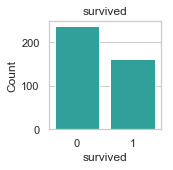

   survived  Count  Percent
0         0    237    59.55
1         1    161    40.45
_________________________________________________________________


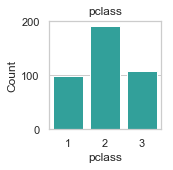

   pclass  Count  Percent
3       2    192    48.24
1       3    108    27.14
2       1     98    24.62
_________________________________________________________________


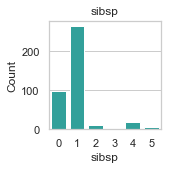

   sibsp  Count  Percent
0      1    265    66.58
1      0     98    24.62
2      4     18     4.52
4      2     10     2.51
3      5      5     1.26
5      3      2     0.50
_________________________________________________________________


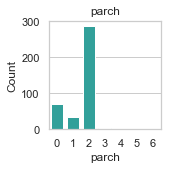

   parch  Count  Percent
0      2    288    72.36
1      0     69    17.34
2      1     34     8.54
5      3      3     0.75
3      6      2     0.50
6      4      1     0.25
4      5      1     0.25
_________________________________________________________________


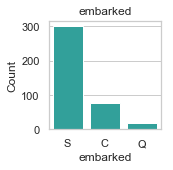

  embarked  Count  Percent
S        S    302    75.88
C        C     77    19.35
Q        Q     19     4.77
_________________________________________________________________


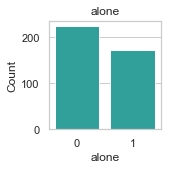

   alone  Count  Percent
1      0    225    56.53
0      1    173    43.47
_________________________________________________________________


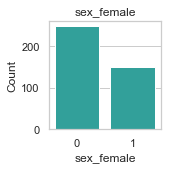

   sex_female  Count  Percent
0           0    249    62.56
1           1    149    37.44
_________________________________________________________________


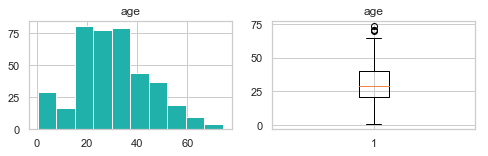

count    398.000000
mean      30.222161
std       14.595995
min        0.420000
25%       21.000000
50%       29.000000
75%       40.000000
max       74.000000
Name: age, dtype: float64


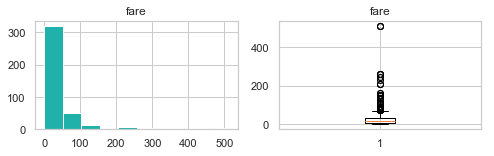

count    398.000000
mean      37.093718
std       61.282772
min        0.000000
25%        8.050000
50%       15.850000
75%       32.875000
max      512.329200
Name: fare, dtype: float64


In [47]:
explore.explore_univariate(train, cat_vars, quant_vars)

**Takeaways & Actions**

- 60% did NOT survive. This will be my baseline prediction to test the usefulness of features on later when we get to modeling. 

- Survived can be treated as either a categorical variable or a number. We can view survived via color on a chart, as categories on the x-axis on a bar chart, or as a proportion between 0 and 1 on the y-axis when viewing another categorical variable to compare "survival rate". 

- We can compare proportions of those who survived and those who didn't with another categorical variable. For example, we can test is female passengers were more or less likely to survive than male passengers using a chi-square test. 

- We can compare the mean of continuous variables between those who survived to those who did not survive using a test such as a t-test or Mann-Whitney test (the non-parametric version of the t-test). Such as, is there a difference in the average fare paid for those who survived vs. those who did not survive? 

- *what else?*

## Bivariate Stats

We will use our `explore_bivariate(train, target, cat_vars, quant_vars)` function that takes in a dataframe, the name of the binary target variable, a list of the names of the categorical variables, a list of the names of the quantitative variables. Each feature is analyzed with respect to the binary target variable. For each categorical variable, a crosstab of frequencies is returned along with the results from a chi-square test that is run, and a barplot. For each quantitative variable, descriptive statistics are computed with respect to the target variable. Difference in means of the quant variable are tested between each class in the target using Mann-Whitney. Finally, a boxenplot and a swarmplot of the target with the quantitative variable are returned.

First, lets verify our lists of variables. 

In [48]:
print(cat_vars)
print(quant_vars)

['survived', 'pclass', 'sibsp', 'parch', 'embarked', 'alone', 'sex_female']
['age', 'fare']


We will want to remove the target variable from that list, as the function takes that variable as a separate argument. 

In [49]:
cat_vars = cat_vars[1:]

pclass 
_____________________

        chi2       p-value  degrees of freedom
0  65.198138  6.956717e-15                   2

observed:
 survived    0    1  All
pclass                 
1          36   72  108
2          49   49   98
3         152   40  192
All       237  161  398

expected:
             0          1
0   64.311558  43.688442
1   58.356784  39.643216
2  114.331658  77.668342


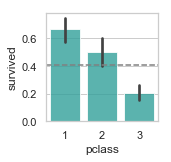


_____________________

sibsp 
_____________________

        chi2   p-value  degrees of freedom
0  10.869694  0.054026                   5

observed:
 survived    0    1  All
sibsp                  
0         168   97  265
1          47   51   98
2           9    9   18
3           3    2    5
4           8    2   10
5           2    0    2
All       237  161  398

expected:
             0           1
0  157.801508  107.198492
1   58.356784   39.643216
2   10.718593    7.281407
3    2.977387    2.022613
4    5.954774    4.045226
5    1.190955    0.809045


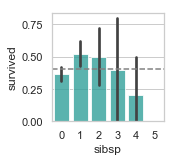


_____________________

parch 
_____________________

       chi2   p-value  degrees of freedom
0  23.68465  0.000597                   6

observed:
 survived    0    1  All
parch                  
0         191   97  288
1          27   42   69
2          14   20   34
3           1    1    2
4           1    0    1
5           2    1    3
6           1    0    1
All       237  161  398

expected:
             0           1
0  171.497487  116.502513
1   41.087940   27.912060
2   20.246231   13.753769
3    1.190955    0.809045
4    0.595477    0.404523
5    1.786432    1.213568
6    0.595477    0.404523


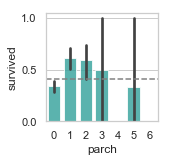


_____________________

embarked 
_____________________

        chi2   p-value  degrees of freedom
0  22.908527  0.000011                   2

observed:
 survived    0    1  All
embarked               
C          28   49   77
Q          15    4   19
S         194  108  302
All       237  161  398

expected:
             0           1
0   45.851759   31.148241
1   11.314070    7.685930
2  179.834171  122.165829


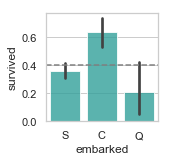


_____________________

alone 
_____________________

        chi2   p-value  degrees of freedom
0  19.653212  0.000009                   1

observed:
 survived    0    1  All
alone                  
0          81   92  173
1         156   69  225
All       237  161  398

expected:
             0          1
0  103.017588  69.982412
1  133.982412  91.017588


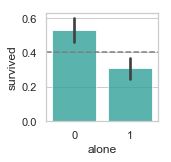


_____________________

sex_female 
_____________________

         chi2       p-value  degrees of freedom
0  116.861777  3.077879e-27                   1

observed:
 survived      0    1  All
sex_female               
0           200   49  249
1            37  112  149
All         237  161  398

expected:
             0           1
0  148.273869  100.726131
1   88.726131   60.273869


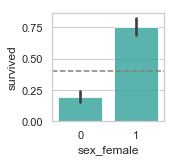


_____________________

age 
____________________



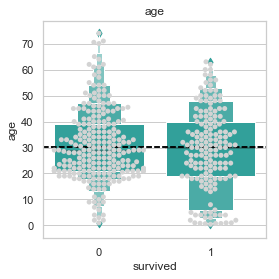

          count       mean        std   min   25%   50%   75%   max
survived                                                           
0         237.0  30.713080  13.953310  1.00  21.0  28.5  39.0  74.0
1         161.0  29.499503  15.509858  0.42  19.0  30.0  40.0  63.0 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=19236.5, pvalue=0.8887609800457109)

____________________

fare 
____________________



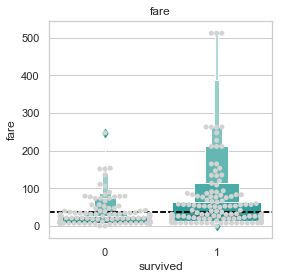

          count       mean        std  min      25%      50%      75%  \
survived                                                                
0         237.0  22.587446  29.093768  0.0   7.8958  10.5167  26.0000   
1         161.0  58.447673  85.436964  0.0  13.0000  26.5500  63.3583   

               max  
survived            
0         247.5208  
1         512.3292   


Mann-Whitney Test:
 MannwhitneyuResult(statistic=10688.5, pvalue=9.330237689194033e-14)

____________________



In [50]:
explore.explore_bivariate(train, 'survived', cat_vars, quant_vars)

**Takeaways**

- bin parch: 0, 1, 2+

- bin sibsp: 0, 1, 2+

- use parch and sibsp in model as opposed to 'alone', but keep alone for exploration and testing purposes as it's easier to view a single variable than 2 variables. 

- children appear more likely to survive. A new feature of is_child, instead of the age might be useful. 

- *What else do you notice?*

In [56]:
# add this to prep, but temporarily I will add them to train. 

train['parch'] = pd.cut(train.parch, bins = [0, 1, 2, 6], right=False, labels=[0, 1, 2])
train['sibsp'] = pd.cut(train.sibsp, bins = [0, 1, 2, 5], right=False, labels=[0, 1, 2])
train['is_adult'] = pd.cut(train.age, bins = [0, 15, 74], right=False, labels=[0, 1])

In [58]:
cat_vars = ['pclass', 'sibsp', 'parch', 'embarked', 'sex_female', 'is_adult']

## Multivariate Stats & Analysis

During this stage, we often add another dimension to our data, such as the target variable as color. We also ask additional, more specific and targeted questions of the data, such as how subgroups compare to each-other and to the overall population.
We then answer these questions using visualizations and/or hypothesis testing.

### Start Generic

First, because we have a categorical target variable, a common approach to visualization is to use color to represent the target, and then plot two features, x and y. 

We will use our function, `explore_multivariate(train, target, cat_vars, quant_vars)` to generate the following: 2 grid plots (swarmplot and violinplot) of categorical variables x quantitative variables, a Pairplot plotting each unique pair of quantitative variables, a single swarmplot visualizing the values of each quantitative variable. For all of these, color represents the target variable. 


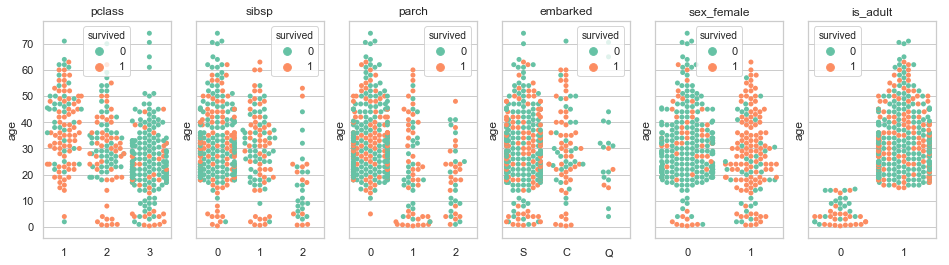

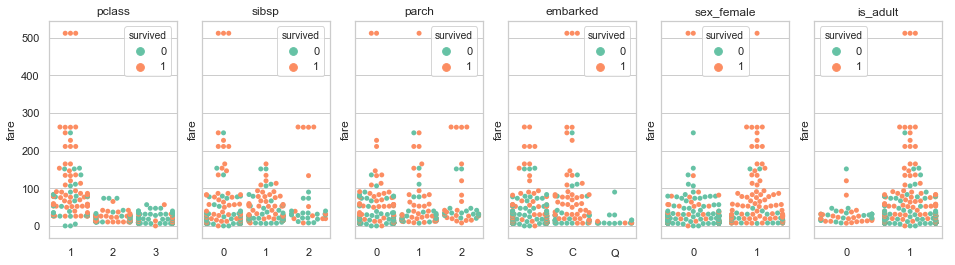

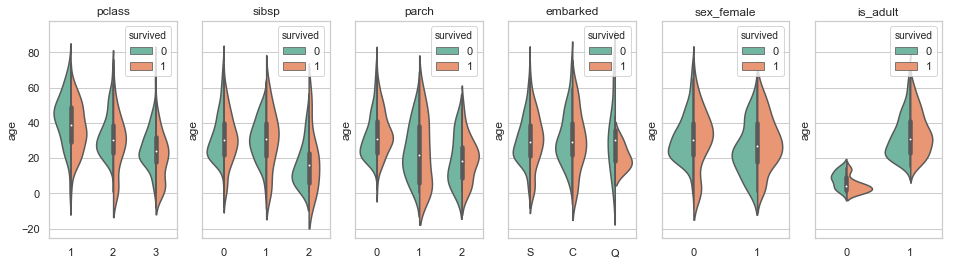

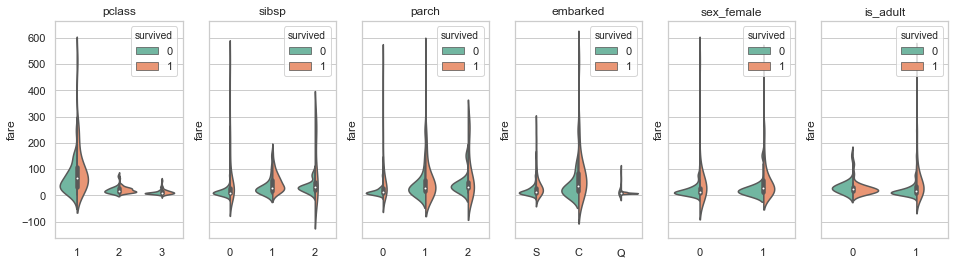

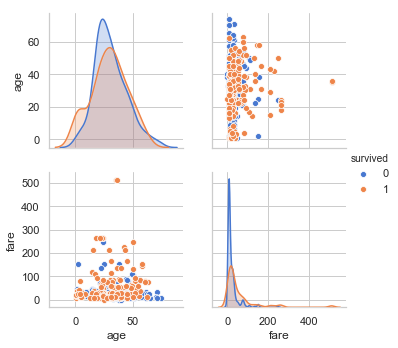

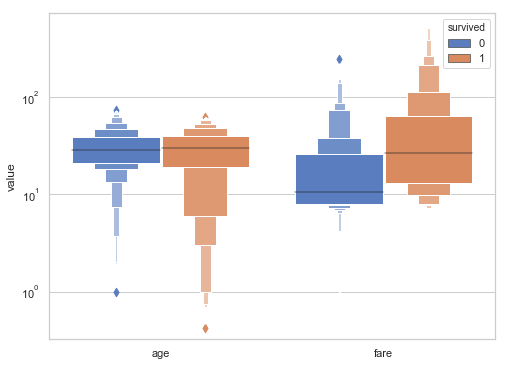

In [59]:
target = 'survived'

explore.explore_multivariate(train, target, cat_vars, quant_vars)

**Takeaways**

*What do you learn from these? What are some actions you wish to take?*

### Get Creative

Ask additional, more specific and targeted questions of the data, such as how subgroups compare to each-other and to the overall population. We then answer these questions using visualizations and/or hypothesis testing.

1. Are male traveling alone less likely to survive than males traveling with others? 
2. Of the females traveling alone, is there a difference in age of who survived and who didn't?
3. Of the females traveling alone, was passenger class the difference in who survived and who didnt?
4. Of passengers in 3rd class, who survived?
5. 3rd class passengers traveling alone...are there any who survived?


**1. Are males traveling alone less likely to survive than males traveling with others?**

- Look at the data. 
- Plot it. 
- Test it. 

alone 
_____________________

       chi2  p-value  degrees of freedom
0  3.133266  0.07671                   1

observed:
 survived    0   1  All
alone                 
0          57  21   78
1         143  28  171
All       200  49  249

expected:
             0          1
0   62.650602  15.349398
1  137.349398  33.650602


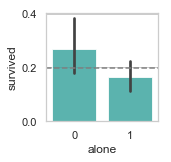


_____________________



In [30]:
male_subset = train[train.sex_female==0]

explore.explore_bivariate_categorical(male_subset, 'survived', 'alone')

**Takeaway**

There is somewhat of a relationship, but at the 90% confidence level, instead of 95%, with a p-value of .077. So while it is not super strong, it does appear that males who were not traveling alone were more likely to survive. My guess is that is because kids are more likely to survive, and adults are more likely to travel alone than kids. 

**2. Of the females traveling alone, is there a difference in age of who survived and who didn't?**

age 
____________________



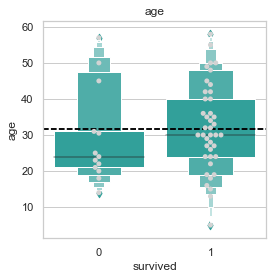

          count       mean        std   min   25%   50%   75%   max
survived                                                           
0          13.0  29.269231  13.239171  14.0  21.0  24.0  31.0  57.0
1          41.0  32.243902  11.920110   5.0  24.0  30.0  40.0  58.0 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=211.0, pvalue=0.2654028056630081)

____________________



In [31]:
solo_females_subset = train[(train.sex_female==1) & (train.alone==1)]

explore.explore_bivariate_quant(solo_females_subset, 'survived', 'age')

There is not a significant difference in the age of the females traveling alone who survived vs. those who did not. 

**3. Of the females traveling alone, was passenger class the difference in who survived and who didnt?**

pclass 
_____________________

        chi2   p-value  degrees of freedom
0  18.344925  0.000104                   2

observed:
 survived   0   1  All
pclass               
1          1  17   18
2          1  16   17
3         11   8   19
All       13  41   54

expected:
           0          1
0  4.333333  13.666667
1  4.092593  12.907407
2  4.574074  14.425926


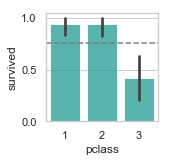


_____________________



In [33]:
explore.explore_bivariate_categorical(solo_females_subset, 'survived', 'pclass')

**Takeaway**

If you were a female traveling alone and you survived, you were likely traveling in first or second class!

**4. Of passengers in 3rd class, who survived?**

pclass 
_____________________

   chi2  p-value  degrees of freedom
0   0.0      1.0                   0

observed:
 survived    0   1  All
pclass                
3         152  40  192
All       152  40  192

expected:
        0     1
0  152.0  40.0


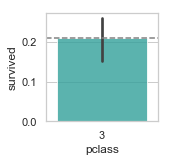


_____________________

sibsp 
_____________________

       chi2   p-value  degrees of freedom
0  2.749468  0.738543                   5

observed:
 survived    0   1  All
sibsp                 
0         110  28  138
1          24   7   31
2           5   3    8
3           3   0    3
4           8   2   10
5           2   0    2
All       152  40  192

expected:
             0          1
0  109.250000  28.750000
1   24.541667   6.458333
2    6.333333   1.666667
3    2.375000   0.625000
4    7.916667   2.083333
5    1.583333   0.416667


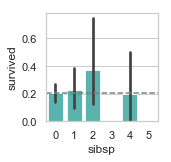


_____________________

parch 
_____________________

        chi2   p-value  degrees of freedom
0  11.371339  0.077556                   6

observed:
 survived    0   1  All
parch                 
0         119  22  141
1          18  12   30
2          10   4   14
3           1   1    2
4           1   0    1
5           2   1    3
6           1   0    1
All       152  40  192

expected:
             0          1
0  111.625000  29.375000
1   23.750000   6.250000
2   11.083333   2.916667
3    1.583333   0.416667
4    0.791667   0.208333
5    2.375000   0.625000
6    0.791667   0.208333


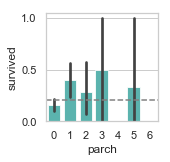


_____________________

embarked 
_____________________

       chi2   p-value  degrees of freedom
0  8.124372  0.017211                   2

observed:
 survived    0   1  All
embarked              
C          13  10   23
Q          14   3   17
S         125  27  152
All       152  40  192

expected:
             0          1
0   18.208333   4.791667
1   13.458333   3.541667
2  120.333333  31.666667


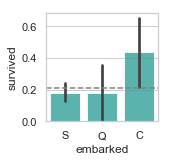


_____________________

alone 
_____________________

       chi2   p-value  degrees of freedom
0  4.771956  0.028927                   1

observed:
 survived    0   1  All
alone                 
0          49  21   70
1         103  19  122
All       152  40  192

expected:
            0          1
0  55.416667  14.583333
1  96.583333  25.416667


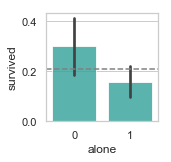


_____________________

sex_female 
_____________________

        chi2       p-value  degrees of freedom
0  28.084358  1.161408e-07                   1

observed:
 survived      0   1  All
sex_female              
0           121  14  135
1            31  26   57
All         152  40  192

expected:
          0       1
0  106.875  28.125
1   45.125  11.875


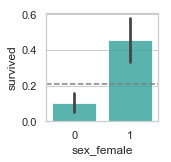


_____________________

age 
____________________



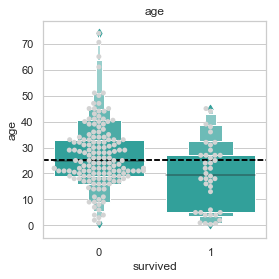

          count       mean        std   min   25%    50%   75%   max
survived                                                            
0         152.0  26.851974  12.507460  1.00  19.0  24.75  33.0  74.0
1          40.0  19.223000  12.875491  0.42   5.0  19.50  27.0  45.0 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=3967.5, pvalue=0.003017714462269748)

____________________

fare 
____________________



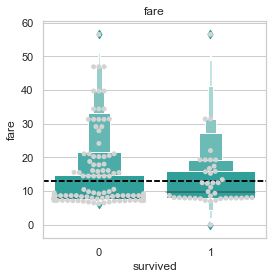

          count       mean       std     min    25%      50%       75%  \
survived                                                                 
0         152.0  12.991665  9.894843  6.2375  7.775  8.05000  14.68645   
1          40.0  13.360312  9.511468  0.0000  7.925  9.59585  16.06250   

              max  
survived           
0         56.4958  
1         56.4958   


Mann-Whitney Test:
 MannwhitneyuResult(statistic=2533.0, pvalue=0.1050112796865297)

____________________



In [34]:
third_class_subset = train[train.pclass==3]

explore.explore_bivariate(third_class_subset, 'survived', cat_vars, quant_vars)

**Takeaways**

Third-class passengers more likely to survive: 

- embarking from Cherbourg
- not traveling alone (specifically traveling with parents or children)
- female
- a child

**5. 3rd class passengers traveling alone...are there any who survived?**

pclass 
_____________________

   chi2  p-value  degrees of freedom
0   0.0      1.0                   0

observed:
 survived    0   1  All
pclass                
3         103  19  122
All       103  19  122

expected:
        0     1
0  103.0  19.0


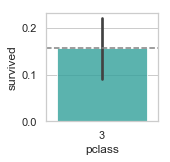


_____________________

sibsp 
_____________________

   chi2  p-value  degrees of freedom
0   0.0      1.0                   0

observed:
 survived    0   1  All
sibsp                 
0         103  19  122
All       103  19  122

expected:
        0     1
0  103.0  19.0


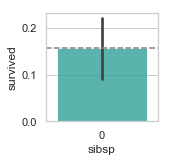


_____________________

parch 
_____________________

   chi2  p-value  degrees of freedom
0   0.0      1.0                   0

observed:
 survived    0   1  All
parch                 
0         103  19  122
All       103  19  122

expected:
        0     1
0  103.0  19.0


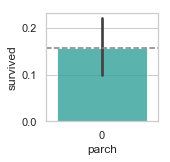


_____________________

embarked 
_____________________

       chi2  p-value  degrees of freedom
0  1.047552  0.59228                   2

observed:
 survived    0   1  All
embarked              
C           7   2    9
Q          10   3   13
S          86  14  100
All       103  19  122

expected:
            0          1
0   7.598361   1.401639
1  10.975410   2.024590
2  84.426230  15.573770


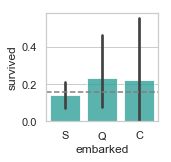


_____________________

alone 
_____________________

   chi2  p-value  degrees of freedom
0   0.0      1.0                   0

observed:
 survived    0   1  All
alone                 
1         103  19  122
All       103  19  122

expected:
        0     1
0  103.0  19.0


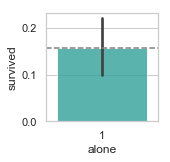


_____________________

sex_female 
_____________________

       chi2   p-value  degrees of freedom
0  9.776822  0.001767                   1

observed:
 survived      0   1  All
sex_female              
0            92  11  103
1            11   8   19
All         103  19  122

expected:
            0          1
0  86.959016  16.040984
1  16.040984   2.959016


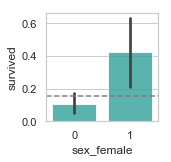


_____________________

age 
____________________



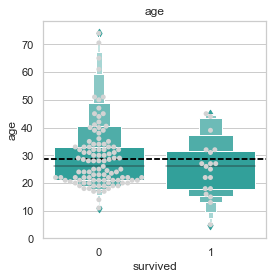

          count       mean        std   min   25%   50%   75%   max
survived                                                           
0         103.0  29.233010  11.579820  11.0  21.0  26.0  33.0  74.0
1          19.0  25.473684  10.383579   5.0  18.0  26.0  31.5  45.0 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=1133.0, pvalue=0.27642486552600076)

____________________

fare 
____________________



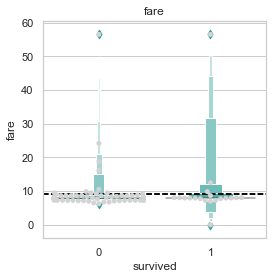

          count       mean        std     min   25%     50%      75%      max
survived                                                                     
0         103.0   8.756024   5.222737  6.2375  7.75  7.8958  8.10415  56.4958
1          19.0  10.326758  11.399911  0.0000  7.75  7.9250  8.05000  56.4958 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=906.5, pvalue=0.6127291965851207)

____________________



In [35]:
solo_third_class_subset = train[(train.pclass==3) & (train.alone==1)]

explore.explore_bivariate(solo_third_class_subset, 'survived', cat_vars, quant_vars)

**Takeaways**

- only 19/103 (18%) of solo, 3rd class customers survived. 
- Of this subset, females were significantly more likely to survive than males. 

## Conclusion

Here we pull all of our takeaways and actions together into one place we can reference as we move forward. 

- add the binning of parch and sibsp to prep: parch => 0, 1, 2+ ; sibsp => 0, 1, 2+

- use parch and sibsp in model as opposed to 'alone', but keep alone for exploration and testing purposes as it's easier to view a single variable than 2 variables. 

- children appear more likely to survive. A new feature of is_child, instead of the age might be useful. 
- remove 'alone' from features, as it is represented through parch and sibsp
- remove embarked, as the dummy variables will need to be used. 
- 60% did NOT survive. This will be my baseline prediction to test the usefulness of features on later when we get to modeling. 

1. Are male traveling alone less likely to survive than males traveling with others? So while it is not super strong, it does appear that males who were not traveling alone were more likely to survive. My guess is that is because kids are more likely to survive, and adults are more likely to travel alone than kids. 

2. Of the females traveling alone, is there a difference in age of who survived and who didn't? There is not a significant difference in the age of the females traveling alone who survived vs. those who did not. 

3. Of the females traveling alone, was passenger class the difference in who survived and who didnt? If you were a female traveling alone and you survived, you were likely traveling in first or second class!

4. Of passengers in 3rd class, who survived? Third-class passengers more likely to survive: embarking from Cherbourg, not traveling alone (specifically traveling with parents or children), female, a child. 

5. 3rd class passengers traveling alone...are there any who survived? only 19/103 (18%) of solo, 3rd class customers survived. Of this subset, females were significantly more likely to survive than males. 

## Exercises

Continue in your `classification_exercises.ipynb` notebook. As always, add, commit, and push your changes.

**Section 1 - iris_db:** Using iris data from our mySQL server and the methods used in the lesson above: 

1. Acquire, prepare & split your data. 

1. Univariate Stats

    - For each measurement type (quantitative variable): create a histogram, boxplot, & compute descriptive statistics (using .describe()). 

    - For each species (categorical variable): create a frequency table and a bar plot of those frequencies. 

    - Document takeaways & any actions. 


2. Bivariate Stats

    - Visualize each measurement type (y-axis) with the species variable (x-axis) using barplots, adding a horizontal line showing the overall mean of the metric (y-axis). 

    - For each measurement type, compute the descriptive statistics for each species. 

    - For virginica & versicolor: Compare the mean petal_width using the Mann-Whitney test (scipy.stats.mannwhitneyu) to see if there is a significant difference between the two groups. Do the same for the other measurement types. 

    - Document takeaways & any actions. 


3. Multivariate Stats

    - Visualize the interaction of each measurement type with the others using a pairplot (or scatter matrix or something similar) and add color to represent species. 

    - Create a swarmplot using a melted dataframe of all your numeric variables. The x-axis should be the variable name, the y-axis the measure. Add another dimension using color to represent species. Document takeaways from this visualization.

    - Ask a specific question of the data, such as: is the sepal area signficantly different in virginica compared to setosa? Answer the question through both a plot and using a mann-whitney or t-test. If you use a t-test, be sure assumptions are met (independence, normality, equal variance). 

    - Document takeaways and any actions. 

